https://medium.com/grabngoinfo/hyperparameter-tuning-and-regularization-for-time-series-model-using-prophet-in-python-9791370a07dc

Import libraries

In [55]:
import pandas as pd
from prophet import Prophet
import itertools
from prophet.diagnostics import cross_validation, performance_metrics

Load dataset and prepare df

In [56]:
file_path = "../data/parsed_dataset.csv"
date_column = "Date_reported"
target_column = "New_deaths"
df = pd.read_csv(file_path, parse_dates=True)
df = df[df[target_column] >= 0]
df = df[[date_column, target_column]]

df.set_index(date_column, inplace=True)
df = df.groupby(date_column).sum().reset_index()

df = df.dropna()
df[target_column] = df[target_column] + 1
df.rename(columns={date_column: 'ds', target_column: 'y'}, inplace=True)
df['floor'] = 0
df['y'].min()

1

Train test split

In [57]:
train = df.iloc[:-30]
test = df.iloc[-30:]

Parameter tuning for order

In [58]:
# Initiate the model
baseline_model = Prophet()# Fit the model on the training dataset
baseline_model.fit(train)

14:00:56 - cmdstanpy - INFO - Chain [1] start processing
14:00:56 - cmdstanpy - INFO - Chain [1] done processing


Create Model

In [59]:
baseline_model_cv = cross_validation(model=baseline_model, initial='365 days', period='30 days', horizon = '30 days', parallel="processes")
baseline_model_cv.head()

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


14:00:57 - cmdstanpy - INFO - Chain [1] start processing
14:00:57 - cmdstanpy - INFO - Chain [1] start processing
14:00:57 - cmdstanpy - INFO - Chain [1] done processing
14:00:57 - cmdstanpy - INFO - Chain [1] start processing
14:00:57 - cmdstanpy - INFO - Chain [1] start processing
14:00:57 - cmdstanpy - INFO - Chain [1] start processing
14:00:57 - cmdstanpy - INFO - Chain [1] start processing
14:00:57 - cmdstanpy - INFO - Chain [1] done processing
14:00:57 - cmdstanpy - INFO - Chain [1] done processing
14:00:57 - cmdstanpy - INFO - Chain [1] done processing
14:00:57 - cmdstanpy - INFO - Chain [1] done processing
14:00:57 - cmdstanpy - INFO - Chain [1] start processing
14:00:57 - cmdstanpy - INFO - Chain [1] done processing
14:00:57 - cmdstanpy - INFO - Chain [1] start processing
14:00:57 - cmdstanpy - INFO - Chain [1] start processing
14:00:58 - cmdstanpy - INFO - Chain [1] start processing
14:00:58 - cmdstanpy - INFO - Chain [1] start processing
14:00:58 - cmdstanpy - INFO - Chain [

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2021-01-07,11888.955938,9385.011424,14303.920219,12300,2021-01-06
1,2021-01-08,12064.883865,9560.759078,14559.944775,12471,2021-01-06
2,2021-01-09,11998.176337,9355.491688,14525.099879,13282,2021-01-06
3,2021-01-10,16022.483059,13551.982785,18543.129391,25952,2021-01-06
4,2021-01-11,11517.246436,9092.540484,14026.128188,11405,2021-01-06


Plot the result

In [60]:
# Model performance metrics
baseline_model_p = performance_metrics(baseline_model_cv, rolling_window=1)
baseline_model_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,30 days,1.158832e+07,3404.162673,2345.37402,3.72278,0.717287,0.907229,0.667647


RMSE of the result

In [61]:
# Get the performance metric value
baseline_model_p['mape'].values[0]

3.7227804411430365

In [62]:
# Initiate the model
manual_model = Prophet(changepoint_range=0.9)# Fit the model on the training dataset
manual_model.fit(train)# Cross validation
manual_model_cv = cross_validation(manual_model, initial='365 days', period='30 days', horizon = '30 days', parallel="processes")# Model performance metrics
manual_model_p = performance_metrics(manual_model_cv, rolling_window=1)
manual_model_p['mape'].values[0]

14:01:03 - cmdstanpy - INFO - Chain [1] start processing
14:01:03 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:01:04 - cmdstanpy - INFO - Chain [1] start processing
14:01:04 - cmdstanpy - INFO - Chain [1] start processing
14:01:04 - cmdstanpy - INFO - Chain [1] done processing
14:01:04 - cmdstanpy - INFO - Chain [1] done processing
14:01:04 - cmdstanpy - INFO - Chain [1] start processing
14:01:04 - cmdstanpy - INFO - Chain [1] start processing
14:01:04 - cmdstanpy - INFO - Chain [1] start processing
14:01:04 - cmdstanpy - INFO - Chain [1] start processing
14:01:04 - cmdstanpy - INFO - Chain [1] start processing
14:01:04 - cmdstanpy - INFO - Chain [1] start processing
14:01:04 - cmdstanpy - INFO - Chain [1] done processing
14:01:04 - cmdstanpy - INFO - Chain [1] start processing
14:01:04 - cmdstanpy - INFO - Chain [1] start processing
14:01:04 - cmdstanpy - INFO - Chain [1] start

3.719905057063154

In [63]:
import numpy as np
# Set up parameter grid
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.05, 0.08, 0.5],
    'seasonality_prior_scale': [0.01, 1, 5, 10, 12],
    'seasonality_mode': ['additive', 'multiplicative']
}# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]# Create a list to store MAPE values for each combination
mapes = [] # Use cross validation to evaluate all parameters
for params in all_params:
    # Fit a model using one parameter combination
    m = Prophet(**params, changepoint_range=0.9).fit(train)  
    # Cross-validation
    df_cv = cross_validation(m, initial='365 days', period='30 days', horizon = '30 days', parallel="processes")
    # Model performance
    df_p = performance_metrics(df_cv, rolling_window=1)
    # Save model performance metrics
    mapes.append(df_p['mape'].values[0])
    
# Tuning results
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mapes# Find the best parameters
best_params = all_params[np.argmin(mapes)]
print(best_params)

14:01:08 - cmdstanpy - INFO - Chain [1] start processing


14:01:08 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:01:10 - cmdstanpy - INFO - Chain [1] start processing
14:01:10 - cmdstanpy - INFO - Chain [1] start processing
14:01:10 - cmdstanpy - INFO - Chain [1] start processing
14:01:10 - cmdstanpy - INFO - Chain [1] done processing
14:01:10 - cmdstanpy - INFO - Chain [1] start processing
14:01:10 - cmdstanpy - INFO - Chain [1] start processing
14:01:10 - cmdstanpy - INFO - Chain [1] done processing
14:01:10 - cmdstanpy - INFO - Chain [1] start processing
14:01:10 - cmdstanpy - INFO - Chain [1] start processing
14:01:10 - cmdstanpy - INFO - Chain [1] done processing
14:01:10 - cmdstanpy - INFO - Chain [1] done processing
14:01:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:01:10 - cmdstanpy - INFO - Chain [1] start processing
14:0

{'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 12, 'seasonality_mode': 'multiplicative'}


In [64]:
# Fit the model using the best parameters
auto_model = Prophet(changepoint_prior_scale=best_params['changepoint_prior_scale'], 
                     seasonality_prior_scale=best_params['seasonality_prior_scale'], 
                     seasonality_mode=best_params['seasonality_mode'], changepoint_range=0.9)# Fit the model on the training dataset
auto_model.fit(train)# Cross validation


pred = auto_model.predict(test[['ds']])
auto_model_cv = cross_validation(auto_model, initial='365 days', period='30 days', horizon = '30 days', parallel="processes")# Model performance metrics
auto_model_p = performance_metrics(auto_model_cv, rolling_window=1)
auto_model_p

14:05:58 - cmdstanpy - INFO - Chain [1] start processing


14:05:59 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:05:59 - cmdstanpy - INFO - Chain [1] start processing
14:05:59 - cmdstanpy - INFO - Chain [1] start processing
14:05:59 - cmdstanpy - INFO - Chain [1] start processing
14:05:59 - cmdstanpy - INFO - Chain [1] start processing
14:05:59 - cmdstanpy - INFO - Chain [1] start processing
14:05:59 - cmdstanpy - INFO - Chain [1] start processing
14:05:59 - cmdstanpy - INFO - Chain [1] start processing
14:06:00 - cmdstanpy - INFO - Chain [1] start processing
14:05:59 - cmdstanpy - INFO - Chain [1] done processing
14:06:00 - cmdstanpy - INFO - Chain [1] start processing
14:06:00 - cmdstanpy - INFO - Chain [1] start processing
14:06:00 - cmdstanpy - INFO - Chain [1] start processing
14:06:00 - cmdstanpy - INFO - Chain [1] start processing
14:06:00 - cmdstanpy - INFO - Chain [1] done processing
14:06:00 - cmdstanpy - INFO - Chain [1] star

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,30 days,2.405337e+07,4904.423582,2556.987252,1.323545,0.596486,0.854744,0.65


In [65]:
pred

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2023-10-24,-293.136677,-2999.524802,2617.860445,-293.136677,-293.136677,-0.522323,-0.522323,-0.522323,-0.232565,-0.232565,-0.232565,-0.289758,-0.289758,-0.289758,0.0,0.0,0.0,-140.024543
1,2023-10-25,-300.604643,-3035.675283,2673.386004,-300.604643,-300.604643,-0.414616,-0.414616,-0.414616,-0.132468,-0.132468,-0.132468,-0.282148,-0.282148,-0.282148,0.0,0.0,0.0,-175.969153
2,2023-10-26,-308.072609,-3232.509945,2671.173574,-308.072609,-308.072609,-0.303513,-0.303513,-0.303513,-0.029701,-0.029701,-0.029701,-0.273811,-0.273811,-0.273811,0.0,0.0,0.0,-214.568695
3,2023-10-27,-315.540575,-3048.360367,2650.254370,-315.540575,-315.540575,-0.276399,-0.276399,-0.276399,-0.011604,-0.011604,-0.011604,-0.264796,-0.264796,-0.264796,0.0,0.0,0.0,-228.325329
4,2023-10-28,-323.008541,-2994.989718,2639.158817,-323.008541,-323.008541,-0.300391,-0.300391,-0.300391,-0.045234,-0.045234,-0.045234,-0.255156,-0.255156,-0.255156,0.0,0.0,0.0,-225.979759
5,2023-10-29,-330.476507,-3484.901710,2648.025793,-330.476507,-330.476507,0.371860,0.371860,0.371860,0.616819,0.616819,0.616819,-0.244959,-0.244959,-0.244959,0.0,0.0,0.0,-453.367426
6,2023-10-30,-337.944473,-3250.199842,2797.065409,-337.944473,-337.944473,-0.399524,-0.399524,-0.399524,-0.165246,-0.165246,-0.165246,-0.234278,-0.234278,-0.234278,0.0,0.0,0.0,-202.927586
7,2023-10-31,-345.412439,-3143.825536,2778.704431,-345.412439,-345.412439,-0.455757,-0.455757,-0.455757,-0.232565,-0.232565,-0.232565,-0.223192,-0.223192,-0.223192,0.0,0.0,0.0,-187.988187
8,2023-11-01,-352.880405,-3145.169583,2669.755426,-352.880405,-352.880405,-0.344256,-0.344256,-0.344256,-0.132468,-0.132468,-0.132468,-0.211787,-0.211787,-0.211787,0.0,0.0,0.0,-231.399364
9,2023-11-02,-360.348371,-2963.254736,2769.487295,-360.348371,-360.348371,-0.229854,-0.229854,-0.229854,-0.029701,-0.029701,-0.029701,-0.200153,-0.200153,-0.200153,0.0,0.0,0.0,-277.520901


In [66]:
from metrics import print_evaluation_metrics

print_evaluation_metrics(pred['yhat'], test['y'])

Evaluation Metrics:
MSE: 206248.20
RMSE: 454.15
MAE: 423.05
MAPE: nan
SMAPE: nan


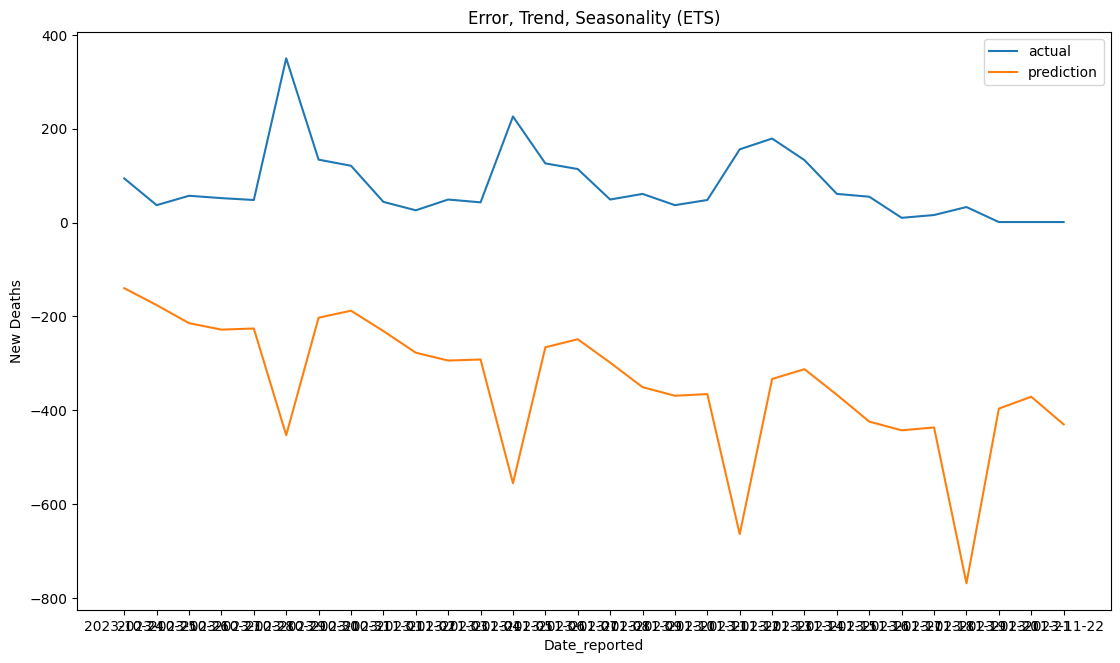

In [67]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(test['ds'], test['y'].values, label="actual")
ax.plot(test['ds'], pred['yhat'], label="prediction")
ax.set_title("Error, Trend, Seasonality (ETS)")
ax.set_ylabel("New Deaths")
ax.set_xlabel(date_column)
ax.legend()
plt.show()

In [68]:
# Create a copy of the data
data_log = df.copy()# Create the log scale data by taking the natual log of the stock prices.
data_log['y_log'] = np.log(df['y'])# Delete the stock price and rename the log scale stock price to y
data_log = data_log.drop('y', axis=1).rename(columns={'y_log': 'y'})# Take a look at the data
data_log.head()

,ds,floor,y
0,2020-01-03,0,0.000000
1,2020-01-04,0,0.000000
2,2020-01-05,0,1.386294
3,2020-01-06,0,0.000000
4,2020-01-07,0,0.000000


In [69]:
# Parameter grid
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.05, 0.08, 0.5],
    'seasonality_prior_scale': [0.01, 1.0, 5, 10, 12],
    'seasonality_mode': ['additive', 'multiplicative']
}# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mapes = []  # Store the MAPEs for each params here# Use cross validation to evaluate all parameters
for params in all_params:
    # Fit a model using one parameter combination
    m = Prophet(**params).fit(data_log)
    # Cross-validation
    df_cv = cross_validation(m, initial='365 days', period='30 days', horizon = '30 days', parallel="processes")
    # Model performance
    df_p = performance_metrics(df_cv, rolling_window=1)
    # Save model performance metrics
    print(df_p)
    mapes.append(df_p['smape'].values[0])# Tuning results
best_params = all_params[np.argmin(mapes)]# Best parameters
print(best_params)# Train model using best parameters
auto_model_log = Prophet(changepoint_prior_scale=best_params['changepoint_prior_scale'], 
                     seasonality_prior_scale=best_params['seasonality_prior_scale'], 
                     seasonality_mode=best_params['seasonality_mode'])# Fit the model on the training dataset
auto_model_log.fit(data_log)# Cross validation
auto_model_log_cv = cross_validation(auto_model_log, initial='365 days', period='30 days', horizon = '30 days', parallel="processes")# Model performance metrics
auto_model_log_p = performance_metrics(auto_model_log_cv, rolling_window=1)
auto_model_log_p

14:06:03 - cmdstanpy - INFO - Chain [1] start processing
14:06:03 - cmdstanpy - INFO - Chain [1] done processing
14:06:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.


14:06:03 - cmdstanpy - INFO - Chain [1] start processing
14:06:11 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:06:12 - cmdstanpy - INFO - Chain [1] start processing
14:06:12 - cmdstanpy - INFO - Chain [1] start processing
14:06:12 - cmdstanpy - INFO - Chain [1] done processing
14:06:12 - cmdstanpy - INFO - Chain [1] start processing
14:06:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:06:12 - cmdstanpy - INFO - Chain [1] done processing
14:06:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
14:06:12 - cmdstanpy - INFO - Chain [1] done processing
Optimization terminated abnormally. Falling back to Newton.
14:06:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
14:06:12 - cmdstanpy - INFO - Chain 

  horizon       mse      rmse      mae     mdape     smape  coverage
0 30 days  5.722198  2.392112  2.16325  0.272052  0.271251  0.315238


14:06:36 - cmdstanpy - INFO - Chain [1] done processing
14:06:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:06:36 - cmdstanpy - INFO - Chain [1] start processing
14:06:44 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:06:45 - cmdstanpy - INFO - Chain [1] start processing
14:06:45 - cmdstanpy - INFO - Chain [1] start processing
14:06:45 - cmdstanpy - INFO - Chain [1] start processing
14:06:45 - cmdstanpy - INFO - Chain [1] done processing
14:06:45 - cmdstanpy - INFO - Chain [1] done processing
14:06:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
14:06:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. 

  horizon       mse      rmse       mae    mdape     smape  coverage
0 30 days  5.206287  2.281729  2.056833  0.26109  0.259957  0.405714


14:07:15 - cmdstanpy - INFO - Chain [1] start processing
14:07:15 - cmdstanpy - INFO - Chain [1] done processing
14:07:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:07:15 - cmdstanpy - INFO - Chain [1] start processing
14:07:23 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:07:24 - cmdstanpy - INFO - Chain [1] start processing
14:07:24 - cmdstanpy - INFO - Chain [1] start processing
14:07:24 - cmdstanpy - INFO - Chain [1] start processing
14:07:24 - cmdstanpy - INFO - Chain [1] start processing
14:07:24 - cmdstanpy - INFO - Chain [1] start processing
14:07:24 - cmdstanpy - INFO - Chain [1] start processing
14:07:24 - cmdstanpy - INFO - Chain [1] done processing
14:07:24 - cmdstanpy - INFO - Chain [1] done processing
14:07:24 - cmdstanpy - ERROR - Chain [1] error: error during

  horizon       mse      rmse       mae     mdape     smape  coverage
0 30 days  7.029781  2.651374  2.393114  0.306929  0.291787   0.25619


14:07:43 - cmdstanpy - INFO - Chain [1] done processing
14:07:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:07:43 - cmdstanpy - INFO - Chain [1] start processing
14:07:49 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:07:50 - cmdstanpy - INFO - Chain [1] start processing
14:07:50 - cmdstanpy - INFO - Chain [1] start processing
14:07:50 - cmdstanpy - INFO - Chain [1] start processing
14:07:50 - cmdstanpy - INFO - Chain [1] start processing
14:07:50 - cmdstanpy - INFO - Chain [1] start processing
14:07:50 - cmdstanpy - INFO - Chain [1] start processing
14:07:50 - cmdstanpy - INFO - Chain [1] done processing
14:07:50 - cmdstanpy - INFO - Chain [1] start processing
14:07:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
14:07:50 - cmdstanpy

  horizon        mse      rmse      mae     mdape     smape  coverage
0 30 days  22.949402  4.790553  3.14574  0.326406  0.328281  0.284762


14:08:03 - cmdstanpy - INFO - Chain [1] start processing


KeyboardInterrupt: 

In [ ]:
pred = auto_model_log.predict(test)
pred = y_pred_original_scale = np.exp(pred['yhat'])


In [ ]:
print_evaluation_metrics(pred, test['y'])

Evaluation Metrics:
MSE: 8401.78
RMSE: 91.66
MAE: 69.71
MAPE: nan
SMAPE: nan


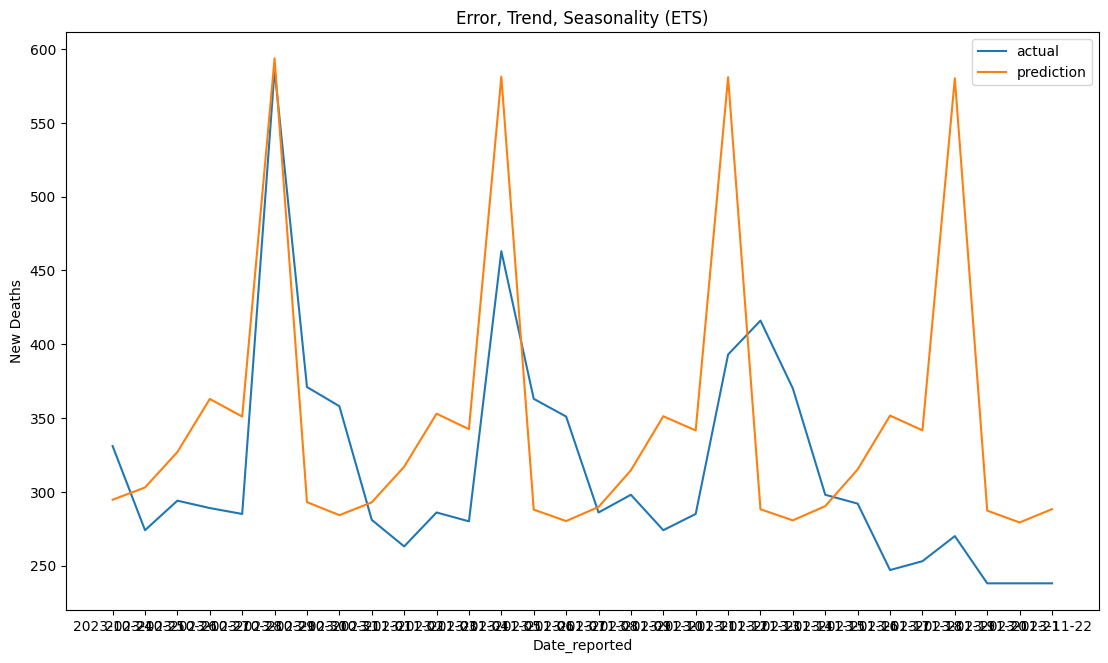

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(test['ds'], test['y'].values, label="actual")
ax.plot(test['ds'], pred, label="prediction")
ax.set_title("Error, Trend, Seasonality (ETS)")
ax.set_ylabel("New Deaths")
ax.set_xlabel(date_column)
ax.legend()
plt.show()